In [3]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from implementations import *
from utilitaries import *
from additional_functions import *

Data loading
===

In [4]:
from proj1_helpers import *

labels, raw_features, indices = load_csv_data('train.csv', sub_sample=False)
# where b(background) -> -1 and s(signal) -> 1
n_samples, n_raw_features = np.shape(raw_features)
print(f'Dimension: {np.shape(raw_features)}')

Dimension: (250000, 30)


Data preprocessing
===

In [5]:
# A vector contaning the indices of features from raw_features kept for analysis:
feature_indices = []

In [6]:
# Converting meaningless -999 to NaN:
features = meaningless_to_nan(raw_features)

In [7]:
# NaN proportion: we believe that features with too many missing 
# values (NaN) are unlikely to carry much useful information (TO BE DISCUSSED):

from utilitaries import *
nan_prop = nan_proportion(features)
print(nan_prop)

[[ 0.        0.        0.        0.        4.        5.        6.
   0.        0.        0.        0.        0.       12.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.       23.       24.       25.       26.       27.
  28.        0.      ]
 [ 0.152456  0.        0.        0.        0.709828  0.709828  0.709828
   0.        0.        0.        0.        0.        0.709828  0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.399652  0.399652  0.399652  0.709828  0.709828
   0.709828  0.      ]]


In [8]:
# For example, we could say : features with p > 0.15 are to be discarded (TO BE DISCUSSED):

reduced_data = np.delete(features, np.s_[0,4,5,6,12,23,24,25,26,27,28], axis=1)
print(f'Dimension: {np.shape(reduced_data)}')

# 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
#   0 1 2       3 4 5 6  7     8  9  10 11 12 13 14 15 16 17                   18

Dimension: (250000, 19)


In [9]:
#We can also standardize the data (TO BE DISCUSSED):

std_data = standardize(reduced_data)
# reshape tx to add offset, ones... c_
print(std_data)

[[ 4.77788214e-02  3.29283583e-01 -5.91818813e-01 ...  9.68083214e-01
   2.01946658e-02  7.99862641e-01]
 [ 3.86320349e-01  4.36268482e-01 -1.92880670e-01 ... -8.95190954e-01
   4.11955167e-04 -5.30940088e-01]
 [ 2.23410465e+00  8.85692102e-01 -4.40382163e-01 ...  1.00133795e+00
   4.11955167e-04 -5.70010941e-01]
 ...
 [ 2.23271248e-01 -1.05698659e-01 -3.58837830e-01 ... -2.15437233e-01
   4.11955167e-04 -6.14700085e-01]
 [-5.91064254e-01 -2.44711767e-01 -8.78193333e-01 ... -1.92048928e+00
  -1.93707555e-02 -1.44541567e+00]
 [ 4.65213799e-01 -2.04770474e-01 -9.97384164e-01 ... -2.18385651e+00
  -1.93707555e-02 -1.44541567e+00]]


Features exploration and selection
===

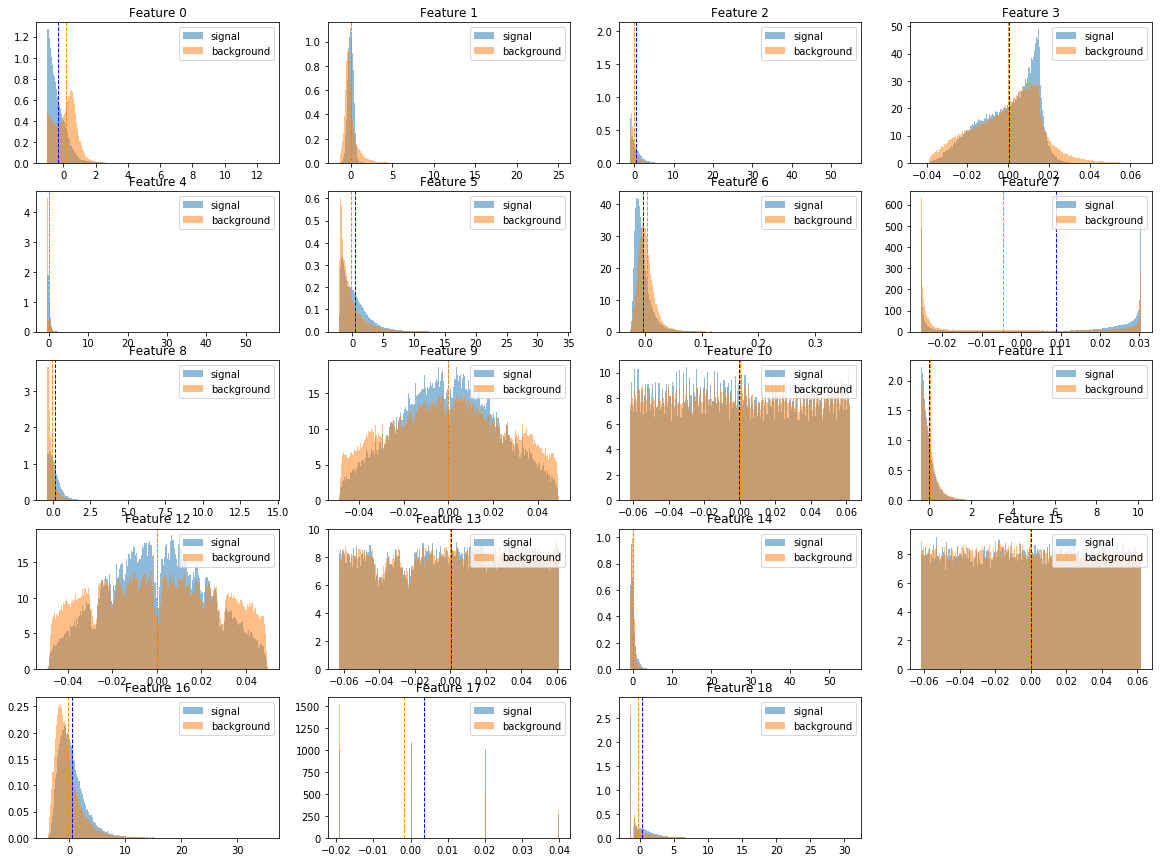

In [10]:
#Let's look at the distribution of each remaining feature:
s_data = std_data[labels == 1,:]
bg_data = std_data[labels == -1,:]
n_samples, n_features = np.shape(std_data)

plt.figure(figsize=(20,15))
peaks = 200

for i in range(n_features):
    plt.subplot(5,4,i+1)
    plt.hist(s_data[:,i][~np.isnan(s_data[:,i])], peaks, density=1, alpha=0.5, label='signal')
    plt.hist(bg_data[:,i][~np.isnan(bg_data[:,i])], peaks, density=1, alpha=0.5, label='background')
    plt.axvline(s_data[:,i][~np.isnan(s_data[:,i])].mean(), color='b', linestyle='dashed', linewidth=1)
    plt.axvline(bg_data[:,i][~np.isnan(bg_data[:,i])].mean(), color='darkorange', linestyle='dashed', linewidth=1)
    plt.legend(loc='upper right')
    plt.title(f'Feature {i}') 

Feature reduction
===

In [23]:
# Does it make sens now that the data is standardized??????

# Mean discrimination
for i in range(n_features):
    threshold_mean = 0.05
    diff_mean = (np.abs(np.abs((s_data[:,i]).mean()) - np.abs((bg_data[:,i]).mean())))/np.abs((standardize_tx[:,i]).mean())
    if diff_mean < threshold_mean:
        print('Diff mean',i,s_data[:,i].mean(),bg_data[:,i].mean(),diff_mean)
    # useless features : 2,4,5,12,15

#low variance filter : data columns with too little changes carry little info
threshold_var = 0.001
variances = np.var(standardize_tx, axis = 0) / np.linalg.norm(standardize_tx, axis = 0)
for i in range(n_features):
    if variances[i] < threshold_var:
        print('Low variance :',i,variances[i])
#useless features: 4,7

#high correlation filter : data columns with similar trends carry similar info
correlation_pairs = np.ones((2,2))
for i in range(n_features):
    for j in range(n_features):
        correlation_pairs = np.corrcoef(standardize_tx[:,i],standardize_tx[:,j])
        #print("feature={f1} and feature={f2}".format(f1=i,f2=j), np.corrcoef(std_data[:,i],std_data[:,j]))
        if correlation_pairs[0,1] > 0.85 and i != j:
            print("feature={f1} and feature={f2}".format(f1=i,f2=j), np.corrcoef(standardize_tx[:,i],standardize_tx[:,j]))
# results: high correlated > 0.85
# features 6 and 17 + 6 and 19 + 17 and 19

# useless feature = 19

Low variance : 4 3.078945592612374e-05
Low variance : 5 0.000875947138652586
Low variance : 7 3.3221109068626193e-05
Low variance : 8 4.693997418094349e-05
Low variance : 9 0.0008813973303817335
Low variance : 10 4.7745931910394886e-05
Low variance : 11 7.144763224180461e-05
Low variance : 12 0.000867744677168799
Low variance : 13 4.974780812357872e-05
Low variance : 14 7.14416631457962e-05
Low variance : 16 7.126907471655635e-05
Low variance : 18 3.8439132404942e-05
feature=6 and feature=17 [[1.         0.90448146]
 [0.90448146 1.        ]]
feature=6 and feature=19 [[1.         0.96562839]
 [0.96562839 1.        ]]
feature=17 and feature=6 [[1.         0.90448146]
 [0.90448146 1.        ]]
feature=17 and feature=19 [[1.         0.88441286]
 [0.88441286 1.        ]]
feature=19 and feature=6 [[1.         0.96562839]
 [0.96562839 1.        ]]
feature=19 and feature=17 [[1.         0.88441286]
 [0.88441286 1.        ]]


(250000, 7)


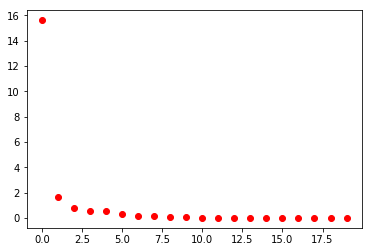

In [30]:
#Principal component analysis:
eig_val, eig_vec = PCA(standardize_tx, 7)
PCA_data = standardize_tx.dot(eig_vec)
print(np.shape(PCA_data))

plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], eig_val, 'ro')

In [31]:
#clean_data_2 = np.delete(standardize_tx, np.s_[2,4,5,7,12,15,19], axis=1)
#clean_data_2 = np.delete(standardize_tx, np.s_[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], axis=1)

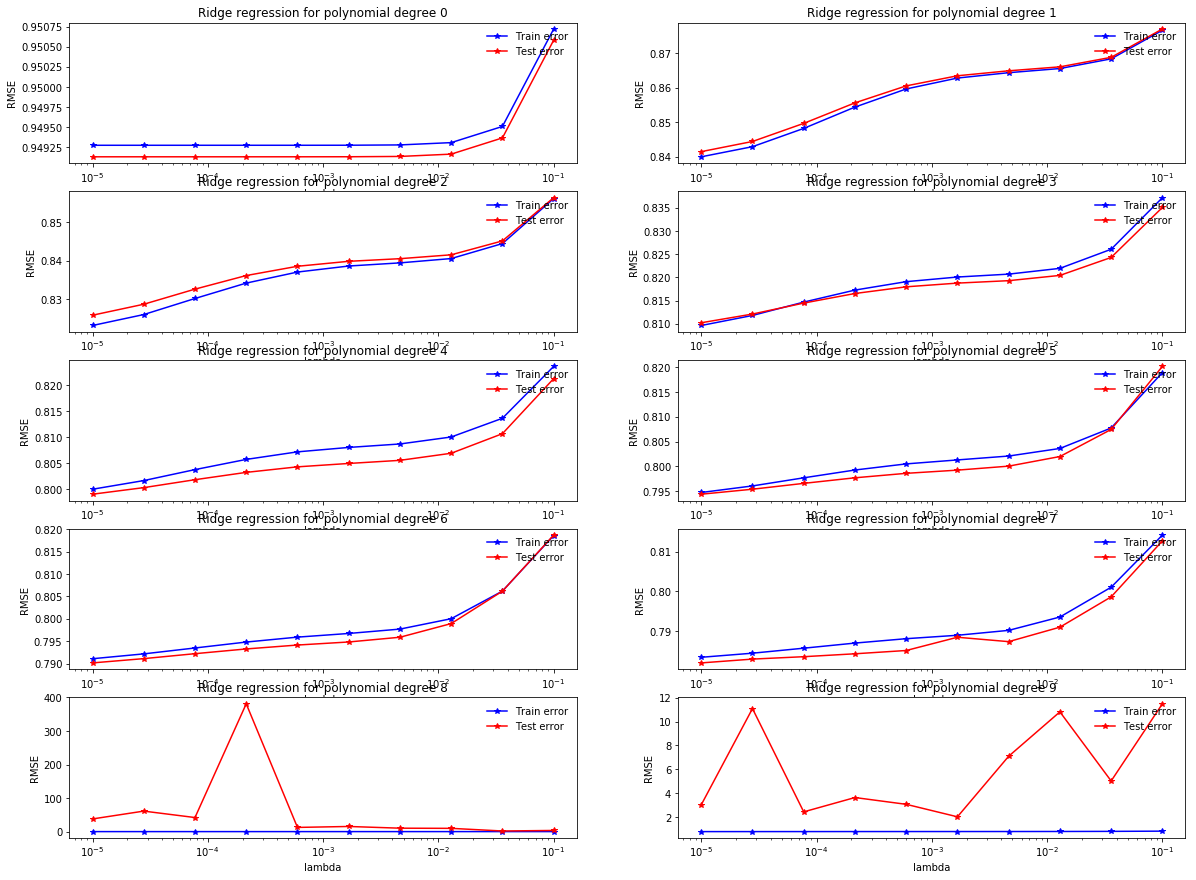

In [39]:
seed = 56
split_ratio = 0.5
plt.figure(figsize=(20,15))

for degree in range(10):
    plt.subplot(5,2,degree+1)
    ridge_regression_demo(standardize_tx,labels,degree, split_ratio, seed)

Submission trials
===

In [20]:
chosen_lambda = 0.001
chosen_degree = 8

data_poly = build_poly(standardize_tx,chosen_degree)
std_data_poly = standardize(data_poly)

weights,loss=ridge_regression(labels,std_data_poly,chosen_lambda)

labels_te,tx_te, indices_te = load_csv_data('test.csv', sub_sample=False)
clean_tx_te = remove_meaningless_data(tx_te, 0.3)
standardize_tx_te = standardize(clean_tx_te)

needed_weights = np.zeros(30)
positions = [0,1,2,3]
for i in range(n_features):
    needed_weights[positions[i]] = weights[i]
print(needed_weights)

y_pred = predict_labels(needed_weights,standardize_tx_te)
create_csv_submission(indices_te, y_pred, 'submission_ridge_1.csv')

[-0.05974807  0.66402959 -0.57298559 -0.05881994  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
